# Setup

In [1]:
# Basics
import anndata as ad
import scvelo as scv
import pandas as pd
import random
import math

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from gseapy.plot import barplot

# cellDancer
import celldancer as cd
import celldancer.utilities as cdutil
import celldancer.cdplt as cdplt
from celldancer.utilities import export_velocity_to_dynamo
from celldancer.cdplt import colormap

# Dynamo
import dynamo as dyn
from dynamo.tools.graph_operators import build_graph, div, potential

The preparations take a significant amount of time. Here, we only show plots output.

See `Object_prep_velo.ipynb` for object creation.

In [2]:
adata = ad.read_h5ad("vascular.h5ad")

In [4]:
# Subset
adata = adata[random.sample(range(0, adata.n_obs), 15000), ] # Downsample

In [ ]:
adata

# Prepare dataset

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # cell amount will influence the setting of n_neighbors

In [ ]:
# Only run once
cellDancer_df = cdutil.adata_to_df_with_embed(
    adata,
    us_para=["Mu", "Ms"],
    cell_type_para="annotation",
    embed_para="X_umap",
    save_path="celldancer_vascular.csv"
)

In [ ]:
cellDancer_df

## Estimate velocity

In [ ]:
# Only run once
cellDancer_df = cd.velocity(cellDancer_df, permutation_ratio=0.5, n_jobs=32)

In [11]:
# Compute cell velocity - only run once
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df[1], projection_neighbor_size=100)

In [15]:
cols = []
levels = cellDancer_df["clusters"].unique()
for i in range(0, len(levels)):
    cols.append(levels[i])

color_mapping = dict(zip(levels, random.sample(colormap.color_template, len(levels))))

In [ ]:
# Plot cell velocity
fig, ax = plt.subplots(figsize=(10,10))
im = cdplt.scatter_cell(ax, cellDancer_df, colors = color_mapping, alpha=1, s=20, velocity=True, legend='on', min_mass=1.5, arrow_grid=(15,15))
ax.axis('off')
plt.show()

In [31]:
# Save CD results - only once
cellDancer_df.to_pickle("celldancer_vascular.pickle")

In [9]:
cols = []
levels = cellDancer_df["clusters"].unique()
for i in range(0, len(levels)):
    cols.append(levels[i])

color_mapping = dict(zip(levels, random.sample(colormap.color_template, len(levels))))

In [4]:
adata = ad.read_h5ad("vascular.h5ad")
adata = adata[adata.obs.index.isin(cellDancer_df.cellID), ]

In [ ]:
adata

## Transfer cellDancer to Dynamo

In [3]:
cellDancer_df = pd.read_pickle("celldancer_vascular.pickle")

In [ ]:
# First create dynamo adata 
dyn.pp.recipe_monocle(adata, n_top_genes=4000, fg_kwargs={"shared_count": 10})
dyn.tl.dynamics(adata, model="static") 

# replace adata.layers['velocity_S'], adata.var['use_for_dynamics'], and adata.var['use_for_transition'] with cellDancer outputs.
adata = export_velocity_to_dynamo(cellDancer_df, adata)

In [36]:
dyn.pp.top_pca_genes(adata, n_top_genes=500)
top_pca_genes = adata.var.index[adata.var.top_pca_genes]
dyn.vf.jacobian(adata, regulators=top_pca_genes[:200], effectors=top_pca_genes[:200], sampling = "random", sample_ncells = 5000)

Transforming subset Jacobian: 100%|██████████| 5000/5000 [00:14<00:00, 345.61it/s]


AnnData object with n_obs × n_vars = 15000 × 36389
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_sampled', 'pca_ddhodge_div', 'pca_potential', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'curvature_pca', 'jacobian_det_pca'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b'

In [37]:
dyn.pd.state_graph(adata, group = "annotation")
dyn.pd.state_graph(adata, group='annotation', basis='pca', method='vf')

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree parameter preparation computation] in progress: 0.0000%|-----> [KDTree computation] completed [0.0038s]
|-----> [iterate groups] in progress: 12.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 219.75it/s]


|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 216.09it/s]


|-----> [iterate groups] in progress: 37.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 206.06it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 209.32it/s]


|-----> [iterate groups] in progress: 62.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 218.20it/s]


|-----> [iterate groups] in progress: 75.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 220.25it/s]


|-----> [iterate groups] in progress: 87.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 202.00it/s]


|-----> [iterate groups] in progress: 100.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 183.61it/s]


|-----> [iterate groups] completed [278.3709s]
|-----> [State graph estimation] completed [0.0020s]
|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree parameter preparation computation] in progress: 0.0000%|-----> [KDTree computation] completed [0.0067s]
|-----> [iterate groups] in progress: 12.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 110.78it/s]


|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 108.84it/s]


|-----> [iterate groups] in progress: 37.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 111.80it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 110.66it/s]


|-----> [iterate groups] in progress: 62.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 107.56it/s]


|-----> [iterate groups] in progress: 75.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 113.64it/s]


|-----> [iterate groups] in progress: 87.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 109.08it/s]


|-----> [iterate groups] in progress: 100.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 109.74it/s]


|-----> [iterate groups] completed [177.1955s]
|-----> [State graph estimation] completed [0.0034s]


AnnData object with n_obs × n_vars = 15000 × 36389
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_sampled', 'pca_ddhodge_div', 'pca_potential', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'curvature_pca', 'jacobian_det_pca'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b'

In [38]:
dyn.vf.rank_acceleration_genes(adata,
                               groups='annotation',
                               akey="acceleration",
                               prefix_store="rank")

dyn.vf.rank_velocity_genes(adata, groups = "annotation")

dyn.vf.rank_acceleration_genes(adata, groups='annotation')

AnnData object with n_obs × n_vars = 15000 × 36389
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_sampled', 'pca_ddhodge_div', 'pca_potential', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'curvature_pca', 'jacobian_det_pca'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b'

In [ ]:
# Annotation
anno = pd.read_csv("vascular.annotation", header = None)
anno.index = anno[1]
anno.index.name = "cells"

new_idx = []
for string in anno.index:
    new_idx.append(string.split(sep = "!!", maxsplit = 1)[1])

anno.index = new_idx

anno = anno[anno.index.isin(adata.obs.index)]
anno = anno.reindex(adata.obs.index)
adata.obs["annotation"] = anno[0]

# Visit
visit = pd.read_csv("all_cells.visits", header = None)
visit.index = visit[1]
visit.index.name = "visit"

new_idx = []
for string in visit.index:
    new_idx.append(string.split(sep = "!!", maxsplit = 1)[1])

visit.index = new_idx

visit = visit[visit.index.isin(adata.obs.index)]
visit = visit.reindex(adata.obs.index)
adata.obs["visit"] = visit[0]

adata.obs

## Plots

In [8]:
cols = []
levels = adata.obs["annotation"].unique()
for i in range(0, len(levels)):
    cols.append(levels[i])

color_mapping = dict(zip(levels, ["#807DBA", "#DADAEB", "#6A51A3", "#54278F", "#9E9AC8", "#BCBDDC", "#3F007D"]))
color_mapping

{'cEC': '#807DBA',
 'arEC': '#DADAEB',
 'vEC': '#6A51A3',
 'Pericytes': '#54278F',
 'SMCs': '#9E9AC8',
 'lEC': '#BCBDDC',
 'cEC2': '#3F007D'}

### Fractions

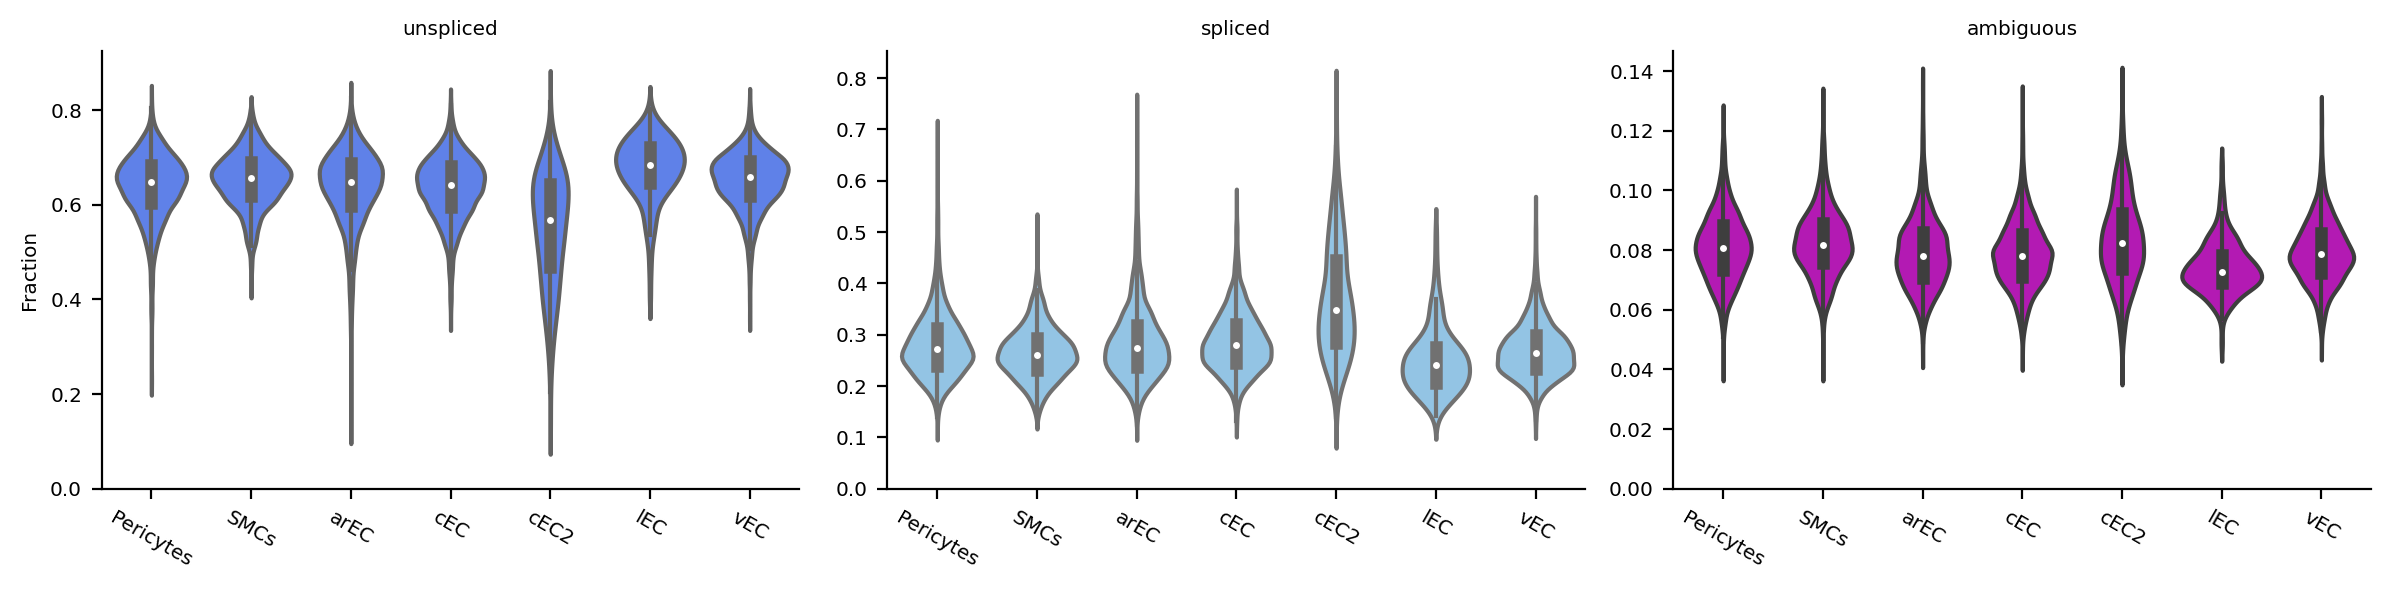

In [9]:
dyn.pl.show_fraction(adata, group = "annotation")

### Streamline plot

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [UMAP] completed [5.9922s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [109.7914s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [3.4746s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is 

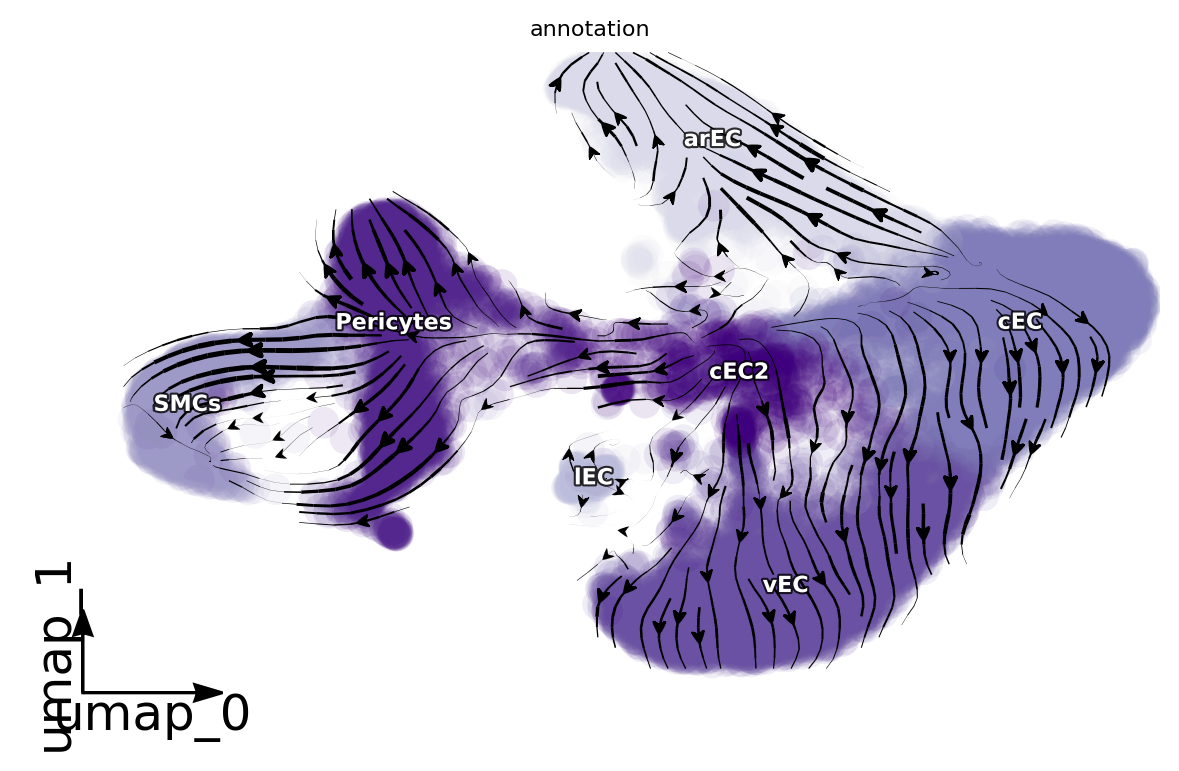

In [14]:
dyn.pl.streamline_plot(adata, color=["annotation"], basis="umap", color_key = color_mapping, show_legend="on data", show_arrowed_spines=True, use_smoothed=True)

#### Only visit 1

In [15]:
adatacp = adata[adata.obs["visit"].str.contains("visit1")]
adatacp

View of AnnData object with n_obs × n_vars = 2694 × 36389
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'visit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'grid_velocity_umap', 'annotation_colors'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_

|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


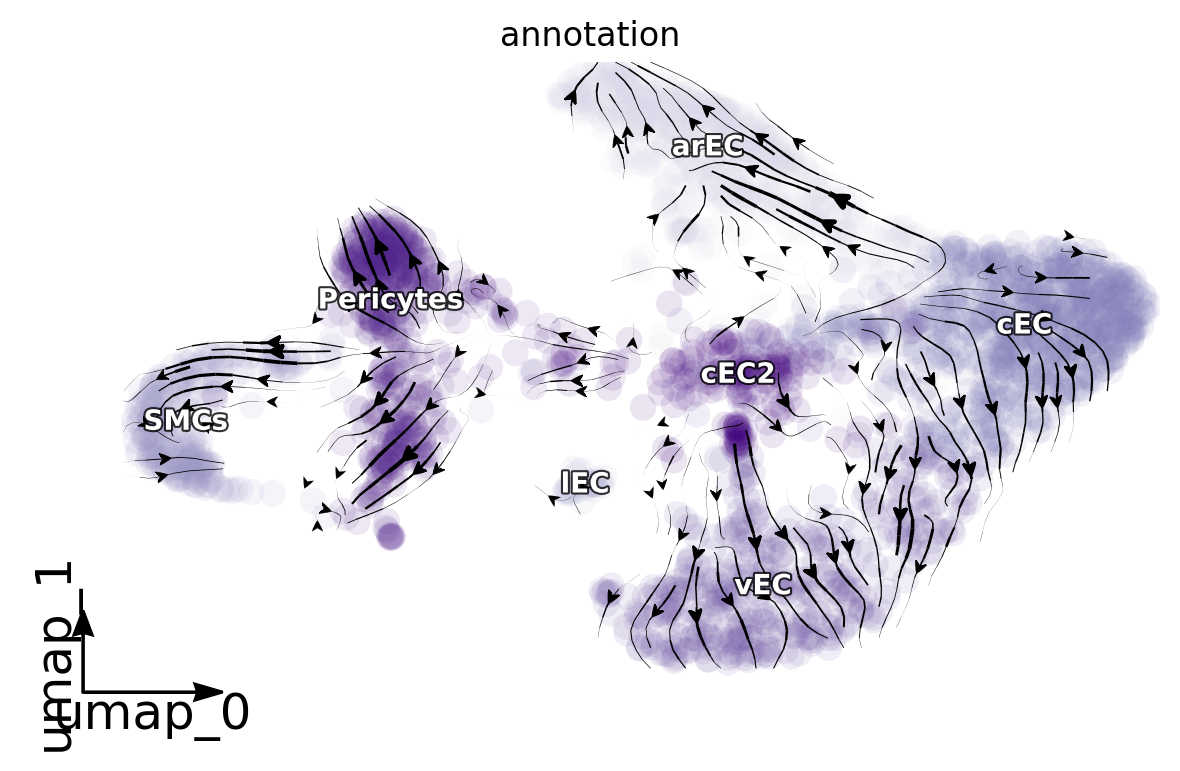

In [19]:
dyn.pl.streamline_plot(adatacp, color=["annotation"], basis="umap", color_key = color_mapping, show_legend="on data", show_arrowed_spines=True, use_smoothed=True, pointsize=0.3, save_show_or_return="show")

#### Only visit 2

In [20]:
adatacp = adata[adata.obs["visit"].str.contains("visit2")]
adatacp

View of AnnData object with n_obs × n_vars = 3040 × 36389
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'visit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'grid_velocity_umap', 'annotation_colors'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_

|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


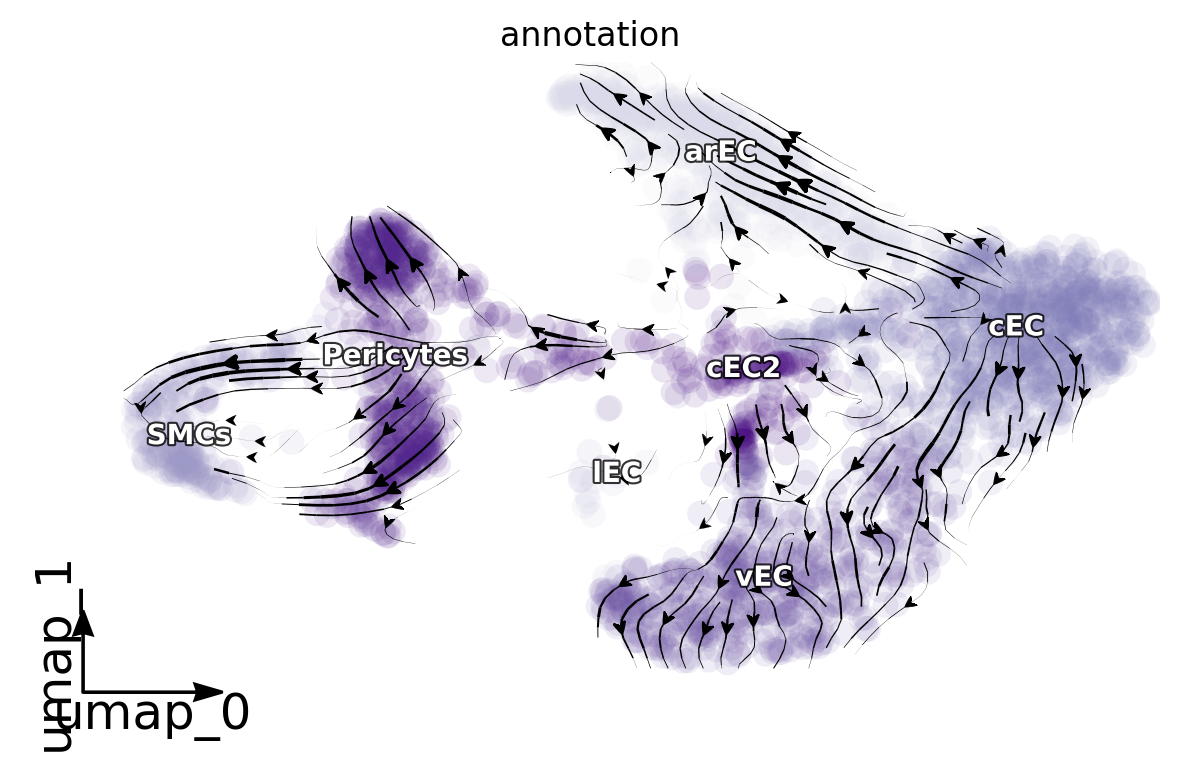

In [21]:
dyn.pl.streamline_plot(adatacp, color=["annotation"], basis="umap", color_key = color_mapping, show_legend="on data", show_arrowed_spines=True, use_smoothed=True, pointsize = 0.3, save_show_or_return="show")

#### Only visit 3

In [22]:
adatacp = adata[adata.obs["visit"].str.contains("visit3")]
adatacp

View of AnnData object with n_obs × n_vars = 9266 × 36389
    obs: 'annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'visit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'grid_velocity_umap', 'annotation_colors'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_

|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


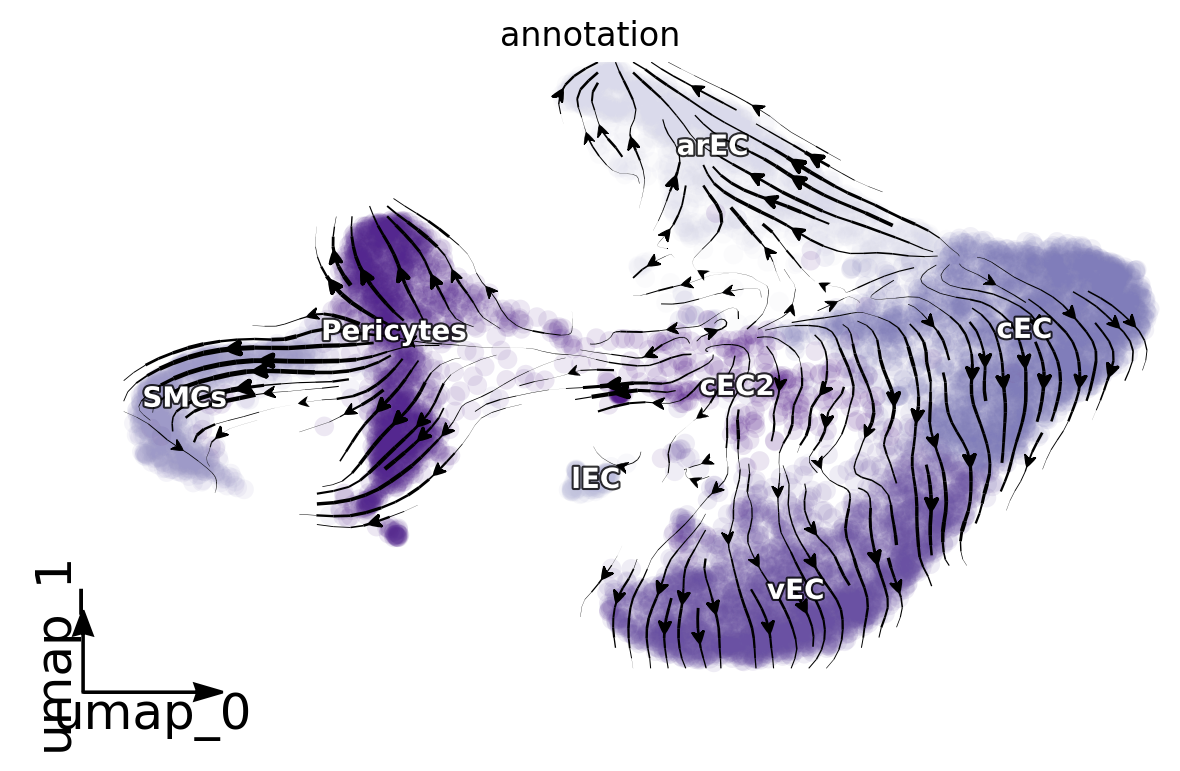

In [23]:
dyn.pl.streamline_plot(adatacp, color=["annotation"], basis="umap", color_key = color_mapping, show_legend="on data", show_arrowed_spines=True, use_smoothed=True, pointsize = 0.3, save_show_or_return = "show")

|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

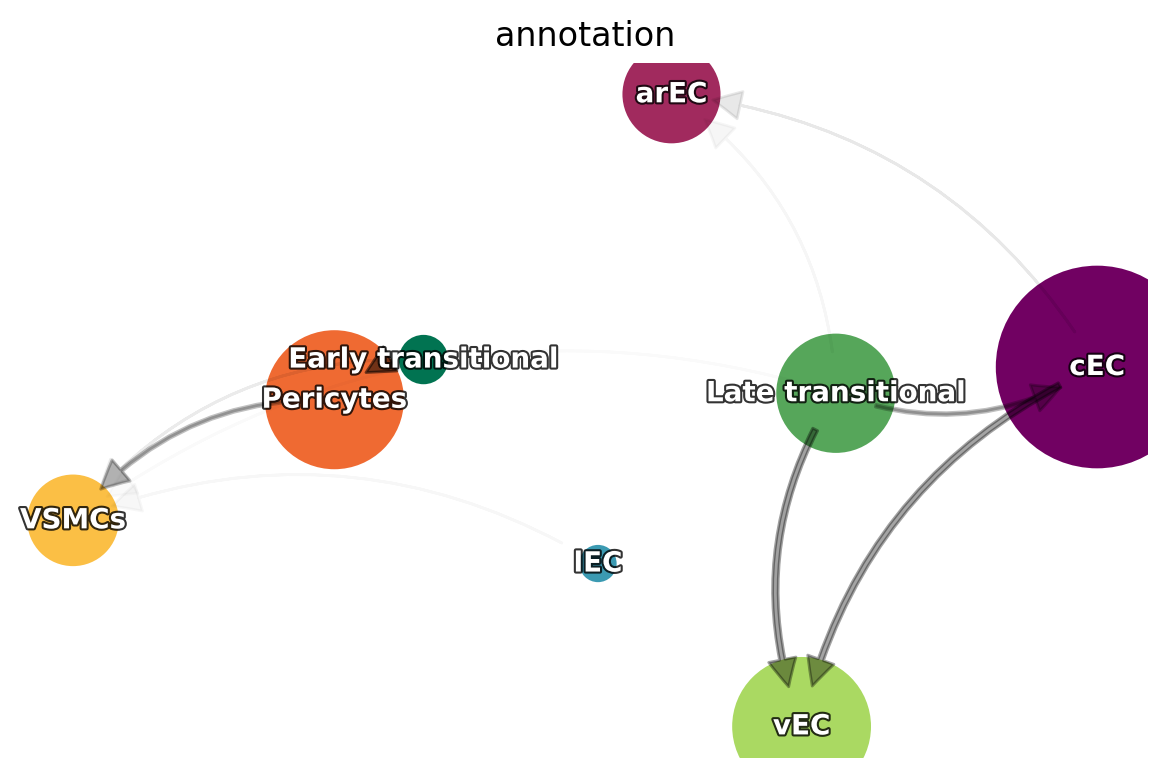

In [47]:
dyn.pl.state_graph(adata, group = "annotation", color = "annotation", color_key=color_mapping, basis = "umap", show_legend="on data")

|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

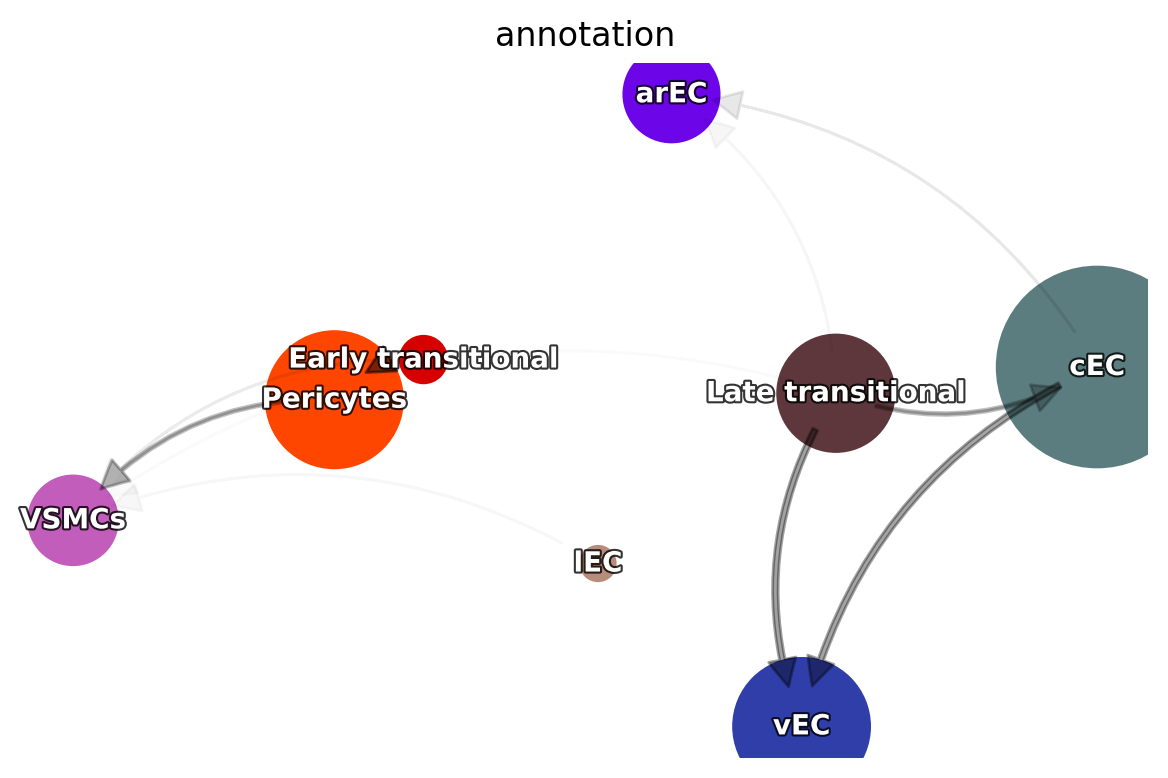

In [48]:
dyn.pl.state_graph(adata,
                   color="annotation",
                   group='annotation',
                   basis='umap',
                   show_legend='on data',
                   method='vf')

|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...
|-----------> plotting with basis key=X_umap


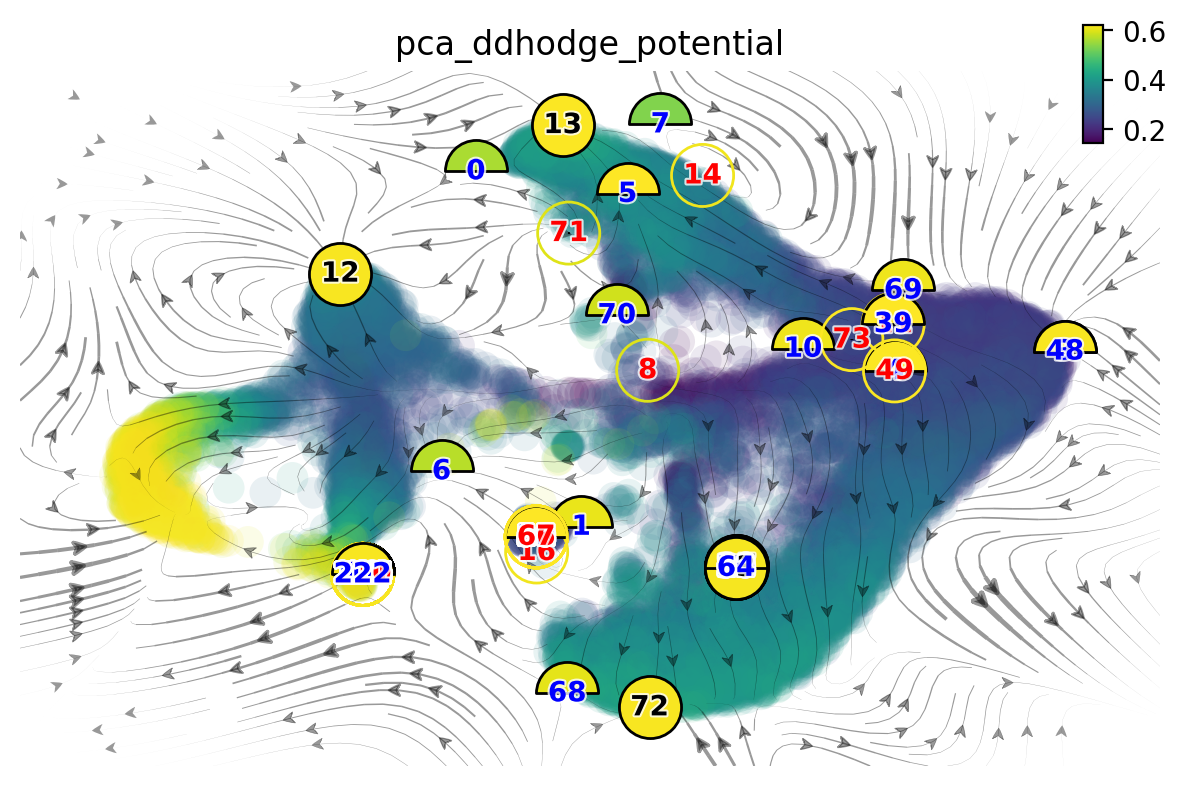

In [49]:
dyn.pl.topography(
    adata,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    color=["pca_ddhodge_potential"],
    show_legend='on data',    
    save_show_or_return='show'
)

In [51]:
adata.uns["rank_velocity_S"][:5]

Early transitional Late transitional   Pericytes       VSMCs    arEC  \
0             MALAT1            MALAT1        SOX5       PRKG1   ARL15   
1               SOX5             RBMS3      MALAT1        SOX5   RBMS3   
2              PRKG1             FBXL7       RBMS3  AC012409.2   MECOM   
3              RBMS3               FTX  AC012409.2       RCAN2  NKAIN2   
4                FTX               B2M      IMMP2L         FTX   LRMDA   

      cEC         lEC         vEC  
0   RBMS3  AC007319.1  AL589693.1  
1  MALAT1  ST6GALNAC3  AC007319.1  
2   FBXL7       FBXL7  AL109930.1  
3   CADM2       EFNA5      ADGRL4  
4    LDB2   LINC02147         FTX

In [52]:
adata.uns["rank_acceleration"][:5]

Early transitional Late transitional Pericytes    VSMCs       arEC  \
0              PRKG1         LINC01697    SORBS2     CD36      FABP4   
1              TSHZ2         LINC01695     PRKG1    TIMP3      TACC1   
2             SLC8A1            PECAM1     MYH11   COL4A1  LINC01697   
3             COL4A2             PLCB4     RBPMS    TACC1      CADM2   
4              ZFHX3             TIMP3     CRIM1  COL25A1       ANO2   

         cEC        lEC    vEC  
0      FKBP5  LINC01697  FABP4  
1  LINC01697       RGS6   XIST  
2      TSHZ2     SORBS2    B2M  
3     PECAM1      CARMN  TIMP3  
4      PLCB4      TMTC1    VWF

In [53]:
jac_rank = dyn.vf.rank_jacobian_genes(
    adata,
    groups="annotation",
    mode="int",
    abs=True,
    output_values=True,
    return_df=True, 
    exclude_diagonal=True
)

In [54]:
jac_rank

lEC    lEC_values               vEC    vEC_values  \
0         OAZ2 - BICC1  6.548730e-04    F13A1 - FILIP1  5.316148e-04   
1         BICC1 - OAZ2  4.988460e-04    FILIP1 - F13A1  4.811424e-04   
2        OAZ2 - TSPAN7  4.829937e-04     FILIP1 - OAZ2  4.075719e-04   
3         OAZ2 - PDE1A  4.648278e-04      F13A1 - TNXB  3.647126e-04   
4          ANO3 - TNXB  4.039186e-04      F13A1 - OAZ2  3.646867e-04   
...                ...           ...               ...           ...   
39795    RAMP2 - NCAM1  2.359984e-08  RIMKLB - SLC38A9  5.377006e-08   
39796     FBLN2 - CDH5  2.272359e-08      CDH5 - SRP14  5.149824e-08   
39797    C2CD2 - FBLN2  2.243702e-08    RIMKLB - FOXN3  5.133549e-08   
39798  SERPINE2 - CDH5  2.214411e-08      FBLN2 - CDH5  5.032441e-08   
39799  FBLN2 - SLC38A9  2.159752e-08    RIMKLB - NCAM1  3.961096e-08   

                     cEC    cEC_values         Pericytes  Pericytes_values  \
0          OAZ2 - FILIP1  4.381240e-04    MAGI2 - PHLPP1      5.257000e-04   
1         F13A1 - FILIP1  3.425990e-04     HNRNPK - ANO3      5.120705e-04   
2          FILIP1 - OAZ2  3.297139e-04     ANO3 - TSPAN7      4.555299e-04   
3            TNXB - OAZ2  2.957344e-04     PDE1A - MAGI2      4.490300e-04   
4           F13A1 - TNXB  2.936873e-04     MAGI2 - PDE1A      4.489342e-04   
...                  ...           ...               ...               ...   
39795  RIMKLB - SERPINE2  5.205723e-08  SLC38A9 - LGALS1      5.544286e-08   
39796      FBLN2 - SRP14  5.079906e-08    SLC38A9 - CDH5      5.427664e-08   
39797     RIMKLB - NCAM1  4.995608e-08    SLC38A9 - PODN      5.233760e-08   
39798     RIMKLB - FOXN3  4.817817e-08    PODN - SLC38A9      5.028814e-08   
39799       FBLN2 - CDH5  4.637851e-08      SRP14 - CDH5      4.252441e-08   

      Late transitional  Late transitional_values                arEC  \
0         OAZ2 - FILIP1              4.385623e-04        F13A1 - OAZ2   
1         FILIP1 - OAZ2              3.823709e-04        F13A1 - TNXB   
2        F13A1 - FILIP1              3.659643e-04      FILIP1 - BICC1   
3          F13A1 - TNXB              3.604514e-04       TNXB - FILIP1   
4          F13A1 - OAZ2              3.595285e-04        TNXB - F13A1   
...                 ...                       ...                 ...   
39795     RIMKLB - CDH5              5.619022e-08    SRP14 - SERPINE2   
39796  RIMKLB - SLC38A9              5.600018e-08       C2CD2 - SRP14   
39797      CDH5 - SRP14              5.410665e-08  SLC38A9 - SERPINE2   
39798    RIMKLB - SRP14              5.364754e-08       C2CD2 - FOXN3   
39799   SLC38A9 - NCAM1              5.037882e-08      RIMKLB - NCAM1   

        arEC_values               VSMCs  VSMCs_values Early transitional  \
0      3.832303e-04        ANO3 - PDE1A  9.382638e-04    PHLPP1 - FILIP1   
1      3.694750e-04        MAGI2 - ANO3  8.869616e-04     MAGI2 - PHLPP1   
2      3.482795e-04        ANO3 - MAGI2  8.275982e-04     FILIP1 - F13A1   
3      3.464634e-04       MAGI2 - PDE1A  7.186741e-04     PHLPP1 - MAGI2   
4      3.292297e-04       ANO3 - PHLPP1  6.895405e-04     MAGI2 - FILIP1   
...             ...                 ...           ...                ...   
39795  4.295822e-08         CDH5 - IER2  4.353154e-08    SLC38A9 - ABCG1   
39796  4.233239e-08     SLC38A9 - NCAM1  4.267490e-08    SLC38A9 - FBLN2   
39797  3.869224e-08  SLC38A9 - SERPINE2  4.085615e-08         CDH5 - GPI   
39798  3.348939e-08        CDH5 - FBLN2  4.023736e-08       SRP14 - CDH5   
39799  3.109065e-08        CDH5 - ABCG1  3.156837e-08       CDH5 - FBLN2   

       Early transitional_values  
0                   6.273446e-04  
1                   4.991436e-04  
2                   4.936397e-04  
3                   4.675357e-04  
4                   4.439107e-04  
...                          ...  
39795               4.856474e-08  
39796               4.811662e-08  
39797               4.748394e-08  
39798               4.564711e-08  
39799               4.012441e-08  

[39800

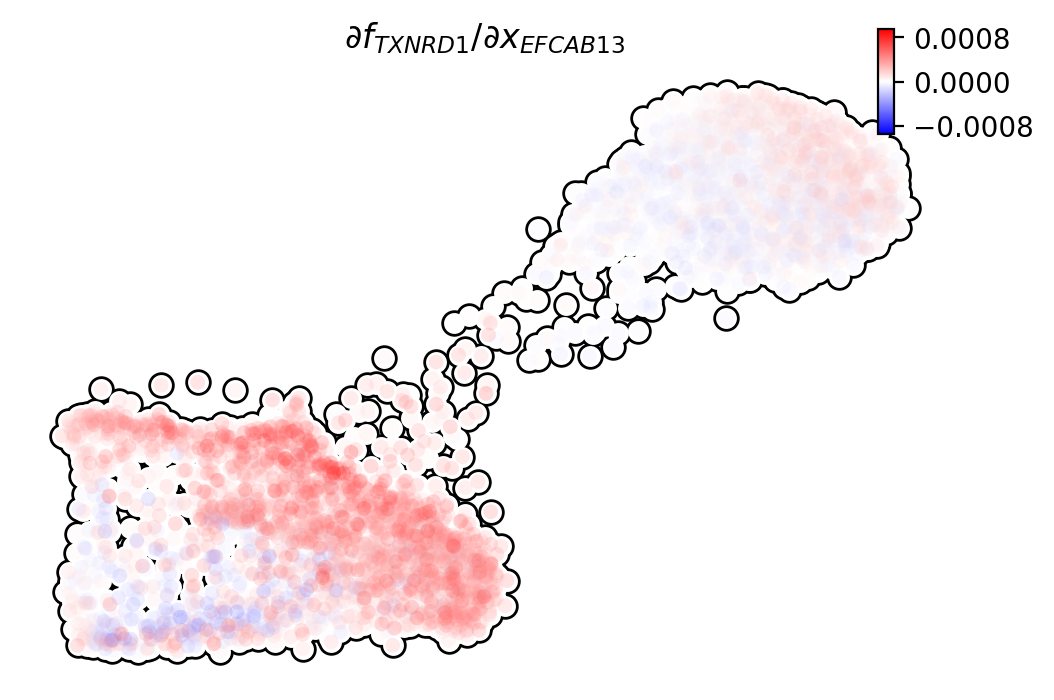

In [15]:
genes = ["PI16","PTPRD","FCGRT","SLC2A13","GPC3","ANTXR1","BASP1"]
dyn.pl.jacobian(adata, regulators = "EFCAB13", effectors = "TXNRD1", basis = "umap")

|-----------> plotting with basis key=X_umap


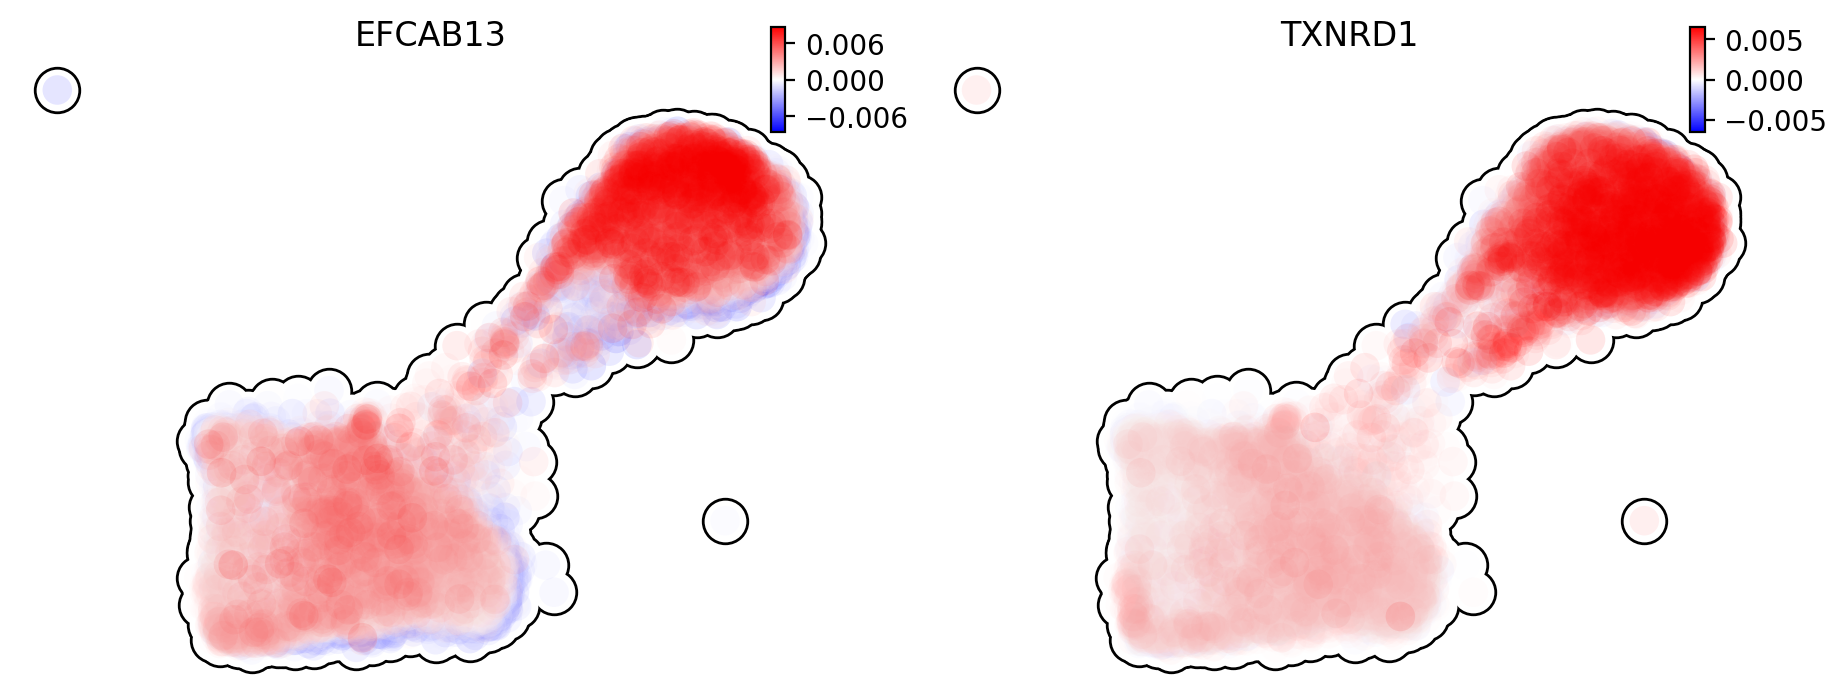

In [16]:
dyn.pl.umap(adata, color=['EFCAB13', 'TXNRD1'], layer='curvature', frontier=True)

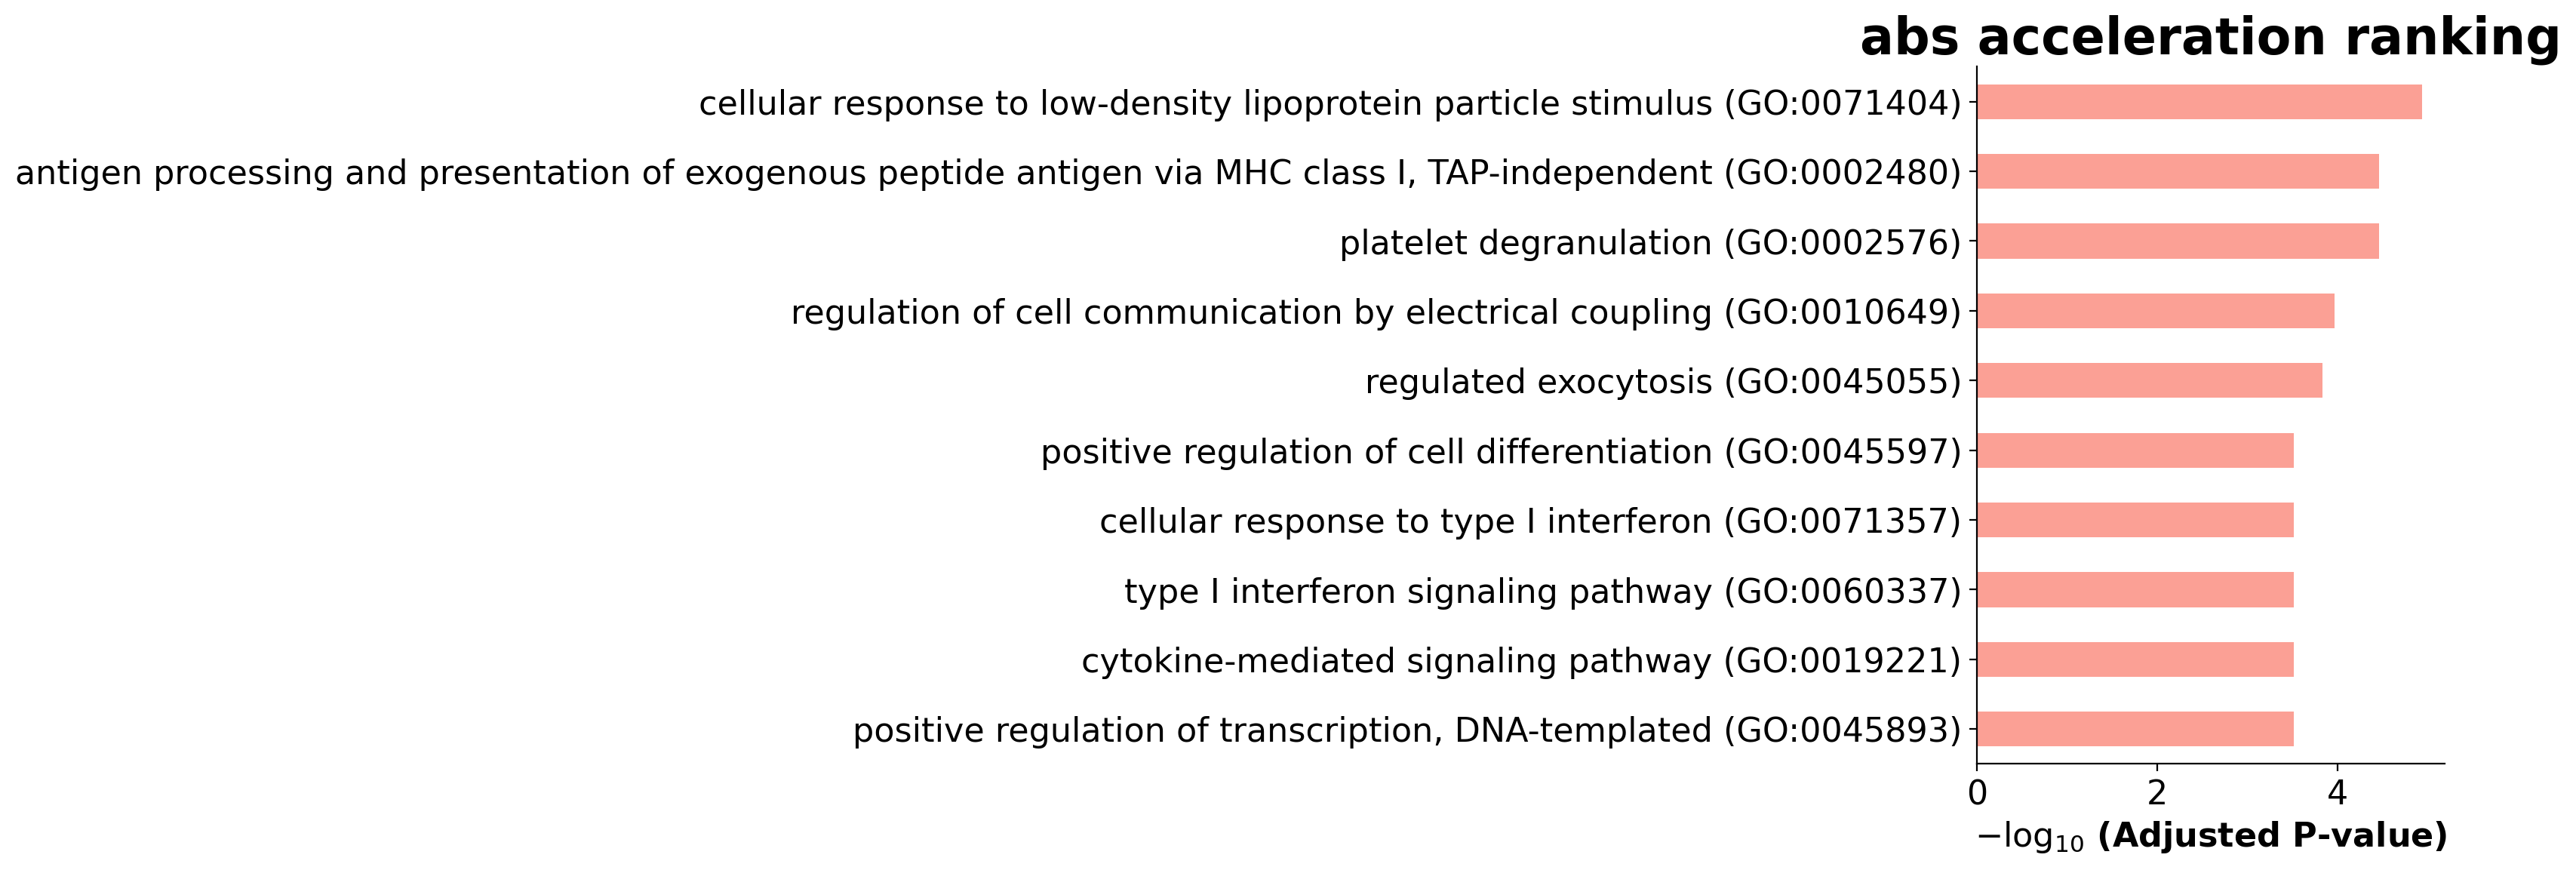

In [55]:
enr = dyn.ext.enrichr(adata.uns['rank_abs_acceleration']['Late transitional'][:250].to_list(), organism='Human', outdir='./enrichr', gene_sets='GO_Biological_Process_2018')
barplot(enr.res2d, title='abs acceleration ranking', cmap='viridis_r', cutoff=0.1)
plt.show()

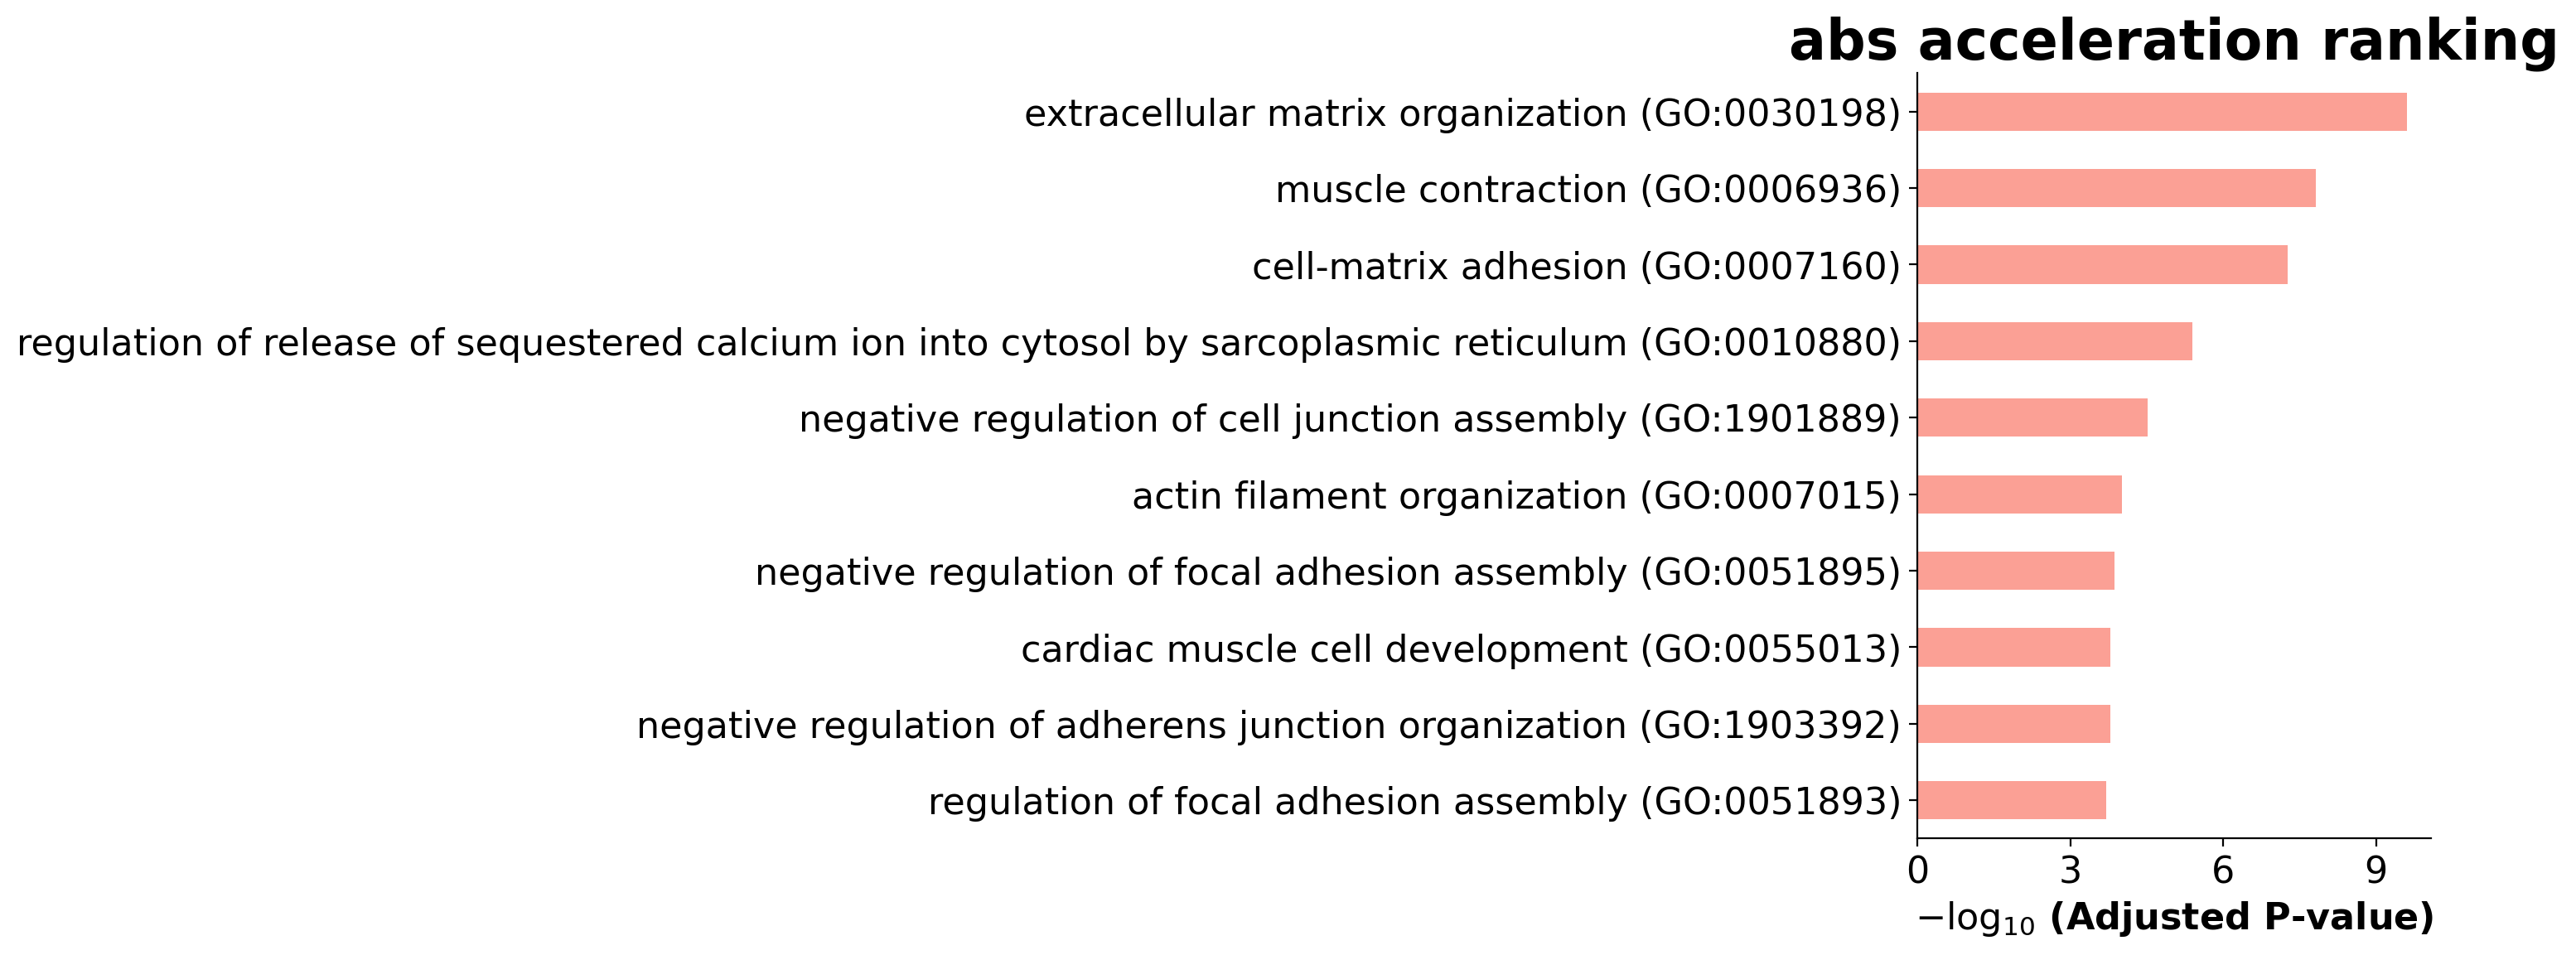

In [56]:
enr = dyn.ext.enrichr(adata.uns['rank_abs_acceleration']['Early transitional'][:250].to_list(), organism='Human', outdir='./enrichr', gene_sets='GO_Biological_Process_2018')
barplot(enr.res2d, title='abs acceleration ranking', cmap='viridis_r', cutoff=0.1)
plt.show()

In [60]:
adata.uns.keys()

odict_keys(['pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'grid_velocity_umap', 'grid_velocity_pca', 'VecFld_pca', 'VecFld_umap', 'jacobian_pca', 'annotation_graph', 'rank_acceleration', 'rank_abs_acceleration', 'rank_velocity_S', 'rank_abs_velocity_S', 'annotation_colors'])

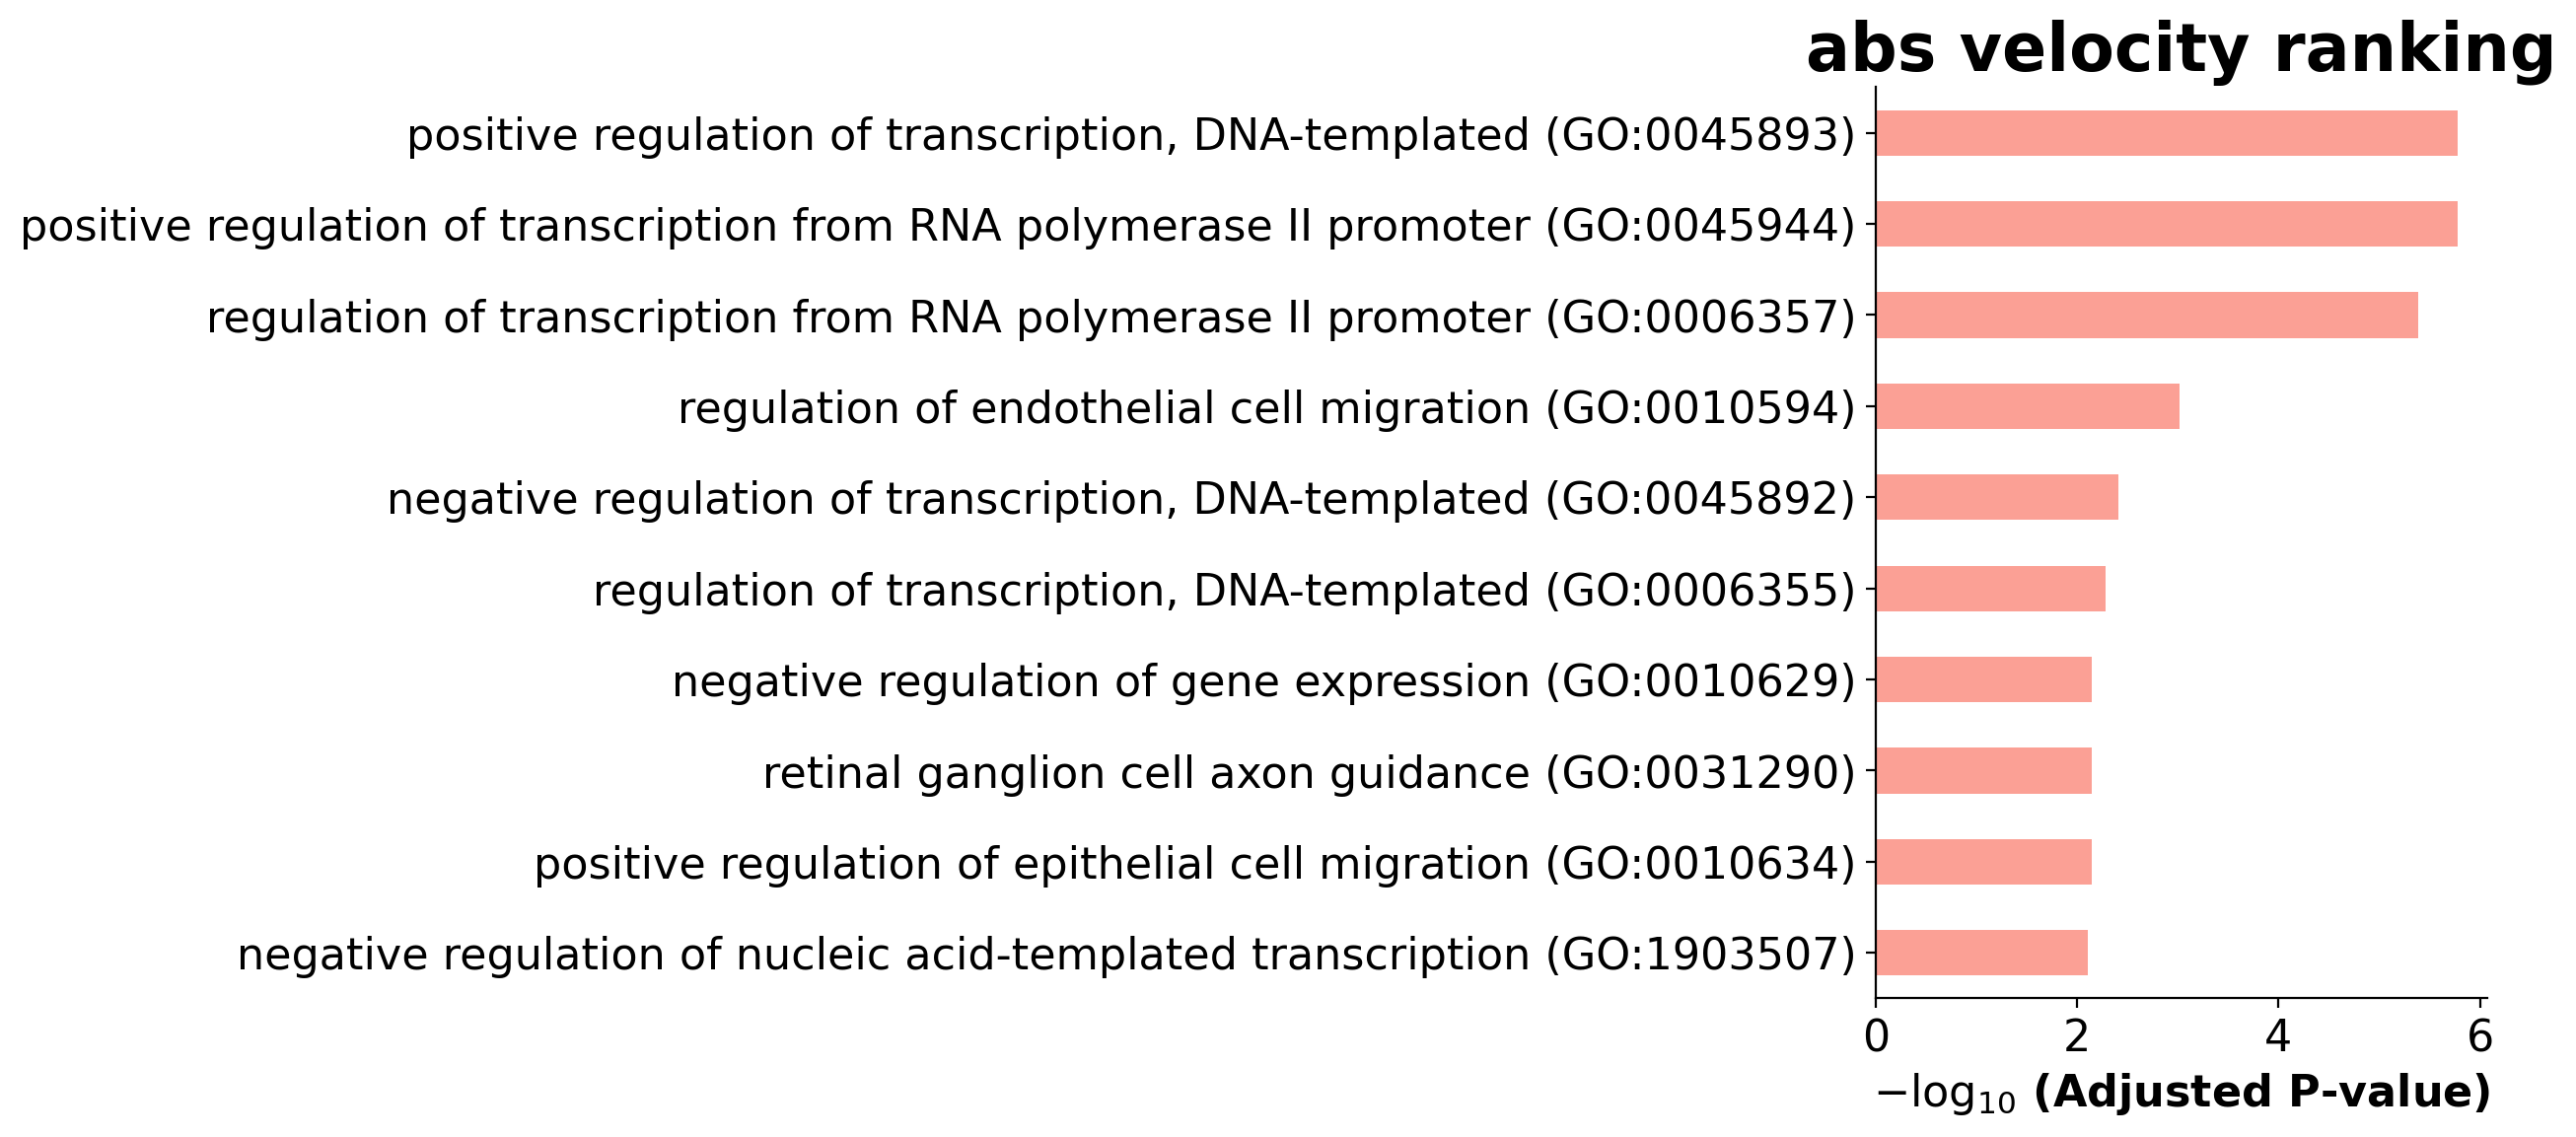

In [61]:
enr = dyn.ext.enrichr(adata.uns['rank_abs_velocity_S']['Late transitional'][:250].to_list(), organism='Human', outdir='./enrichr', gene_sets='GO_Biological_Process_2018')
barplot(enr.res2d, title='abs velocity ranking', cmap='viridis_r', cutoff=0.1)
plt.show()

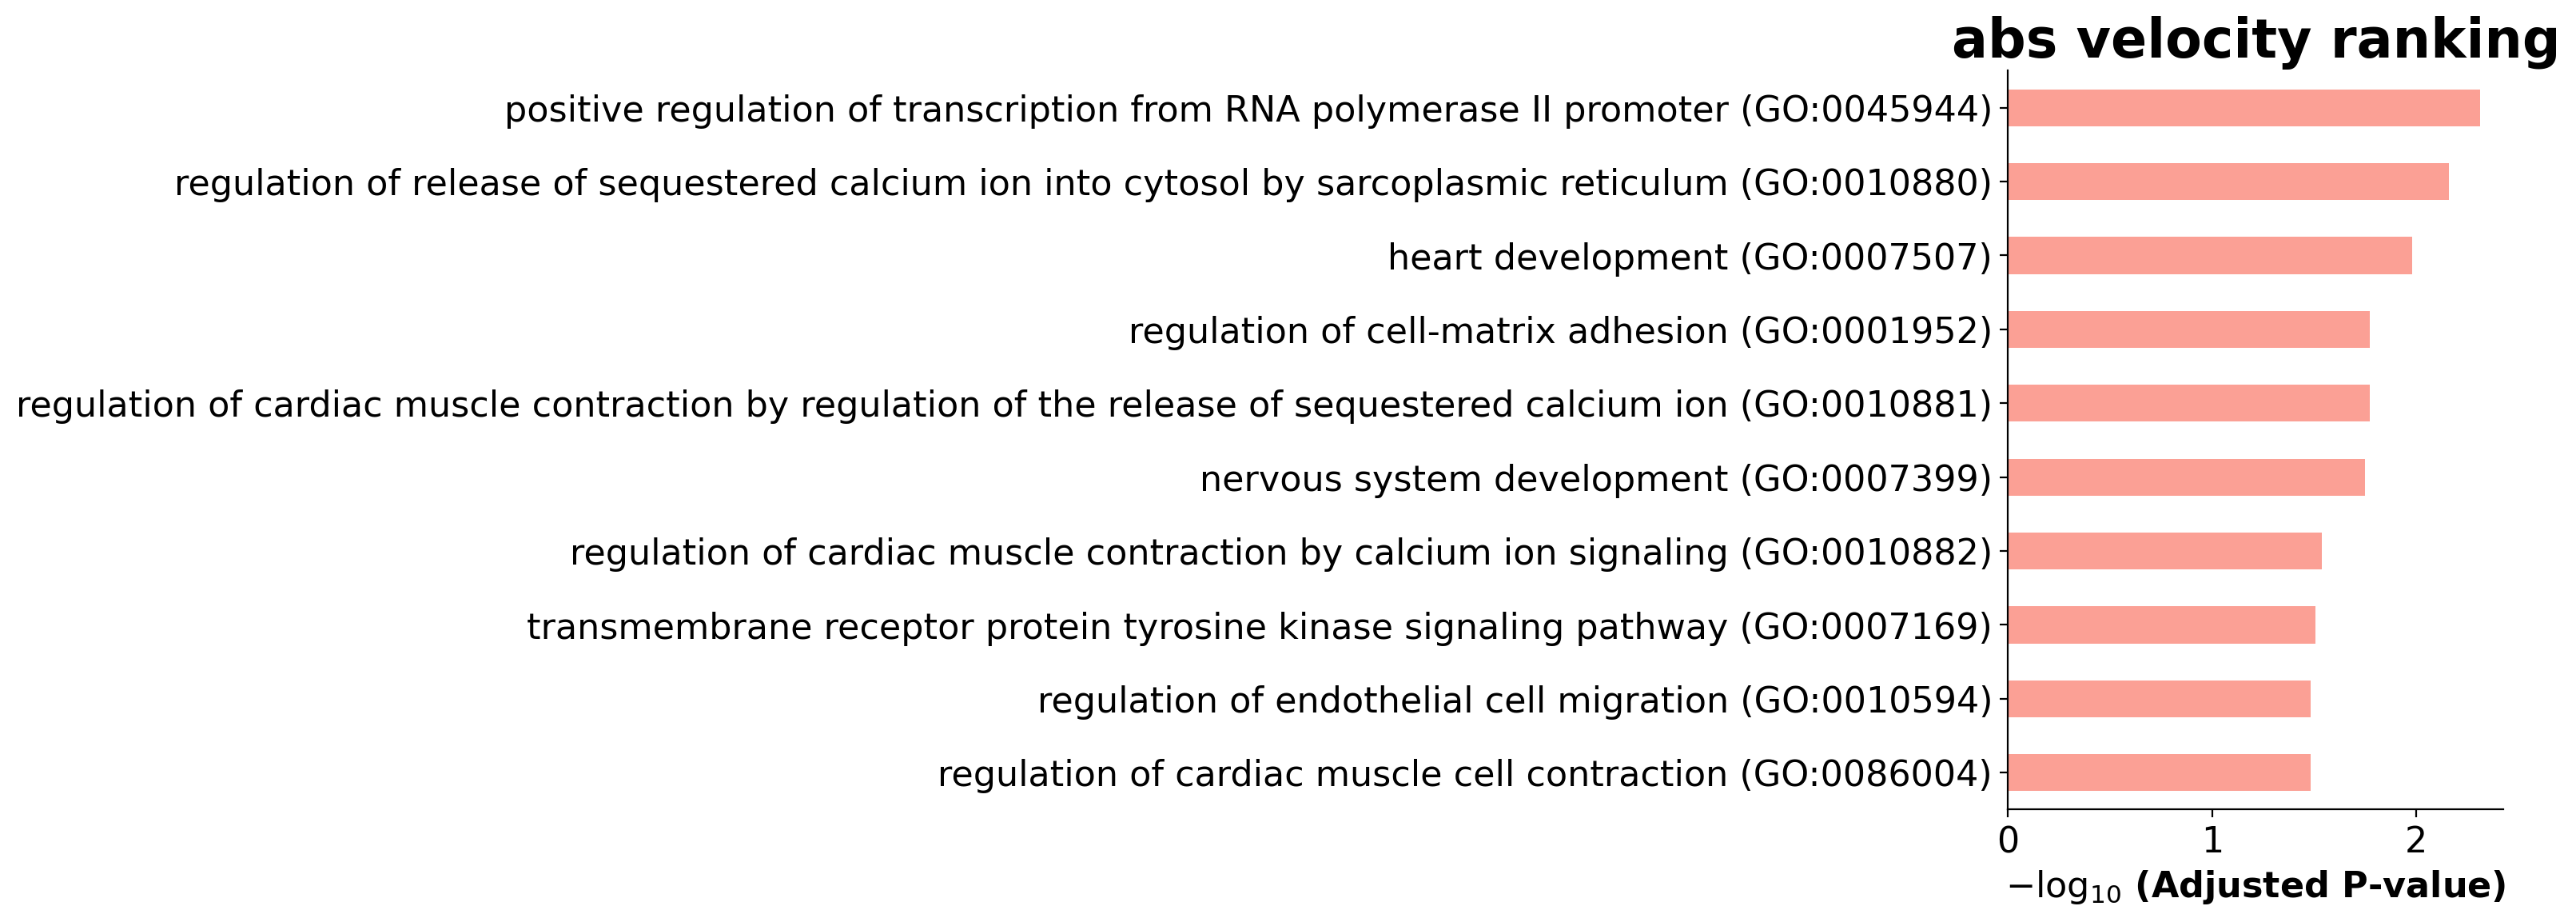

In [62]:
enr = dyn.ext.enrichr(adata.uns['rank_abs_velocity_S']['Early transitional'][:250].to_list(), organism='Human', outdir='./enrichr', gene_sets='GO_Biological_Process_2018')
barplot(enr.res2d, title='abs velocity ranking', cmap='viridis_r', cutoff=0.1)
plt.show()